<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/t_SNE_Tutorial_PyLibML_3_4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference
* t-SNE를 이용한 매니폴드학습
* python library를 활용한 머신러닝 - 안드레아스뮐러저-

### Goal of this tutorial
* how to apply t-SNE Algorithm to Data
* learn & apply it to My Data
* 20.07.02.thur

manifold learning algorithm이라고 하는 시각화 알고리즘들은 훨씬 복잡한 매핑을 만들어 더 나은 시각화를 제공한다.

* t-SNE 알고리즘에 대해 학습해보자
* t-SNE를 어떤 데이터에도 적용할 수 있도록 학습해보자

* manifold algorithm이란
    * manifold algorithm은 그 목적이 시각화라 3개 이상의 특성을 뽑는 경우는 거의 없다.
    * t-SNE를 포함한 일부 매니폴드 알고리즘들은 훈련 데이터를 새로운 표현으로 변환시키지만 새로운 데이터에는 적용하지 못한다.
    * 즉 테스트 세트에는 적용할 수 없고, 단지 훈련했던 데이터만 변환할 수 있다.
    * 따라서 manifold학습은 데이터 탐색적 데이터 분석(Exploratory Data Analysis)에 유용하지만 지도학습용으로는 거의 사용하지 않는다.

위의 점으로 미루어보아. 학습데이터로부터 추출한 특징 벡터들을 표현하는데 적합한 알고리즘인 것 같다.(실험을 통해 확인해보자)

* t-SNE의 아이디어
    * 데이터 포인트 사이의 거리를 가장 잘 보존하는 2차원 표현을 찾는 것이다.
    * 먼저 t-SNE는 각 데이터 포인트를 2차원에 무작위로 표현한 후 원본 특성 공간에 가까운 포인트는 가깝게, 멀리 떨어진 포인트는 멀어지게 만든다.
    * t-SNE는 멀리 떨어진 포인트와 거리를 보존하는 것보다 가까이 있는 포인트에 더 많은 비중을 둔다
    * 다시 말해, 이웃 데이터 포인트에 대한 정보를 보전하려 노력한다.


scikit-learn에 있는 손글씨 숫자 데이터셋에 t-SNE 매니폴드 학습을 적용해보도록하자

이 데이터셋의 각 포인트는 0에서 9사이의 손글씨 숫자를 표현한 8x8크기의 흑백 이미지이다.

---
t-SNE란 t-Distribution Stochastic Neighbor Embedding의 약자이다.

In [13]:
%load_ext autoreload
% autoreload 2

In [14]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 실습

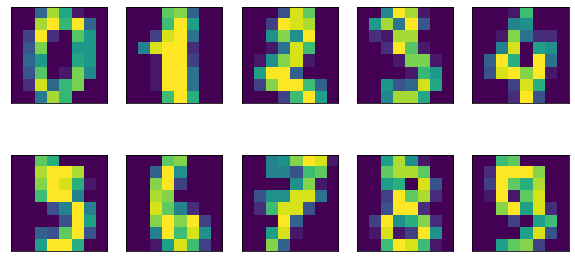

In [3]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                         subplot_kw={'xticks':(),'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

우선 PCA를 사용해 데이터를 2차원으로 축소해 시각화해보도록 한다.

처음 두 개의 주성분을 이용해 그래프를 그리고 각 샘플을 해당하는 클래스의 숫자로 나타냈다.

### 01. PCA

In [18]:
digits.data.shape

(1797, 64)

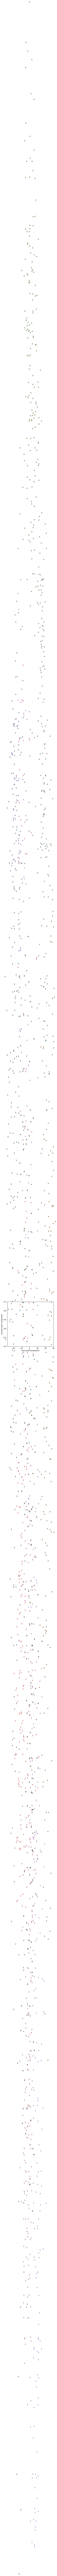

In [16]:
# PCA 모델 생성

from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca.fit(digits.data)

# 처음 두 개의 주성분으로 숫자 데이터 변환
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

plt.figure(figsize=(5, 5))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:,0].max())
plt.xlim(digits_pca[:, 1].min(), digits_pca[:,1].max())


for i in range(len(digits.data)):
    # 숫자 텍스트를 이용해 산점도를 그린다
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight':'bold', 'size':9})
plt.xlabel("first main component")
plt.ylabel("second main component")
plt.savefig('./pca_tutorial.png', dpi=300)
plt.show()

같은 데이터셋에 t-SNE를 적용해 결과비교<br>
t-SNE는 새데이터를 변환하는 기능을 제공하지 않으므로 transform 메서드가 없다. <br>
대신 모델을 만들자마자 데이터를 변환해주는 fit_transform 메서드를 사용할 수 있다.

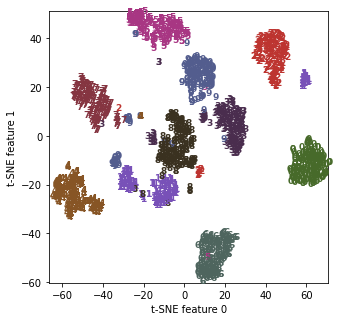

In [21]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# TSNE에는 transform 메서드가 없으므로 대신 fit_transform을 사용한다.
digits_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(5,5))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:,0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:,1].max() + 1)

for i in range(len(digits.data)):
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight':'bold', 'size':9})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.savefig('./t_SNE_tutorial.png', dpi=300)


## Simple t-SNE
* from sklearn documentation<br>
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [24]:
import numpy as np
from sklearn.manifold import TSNE

X = np.array([[0, 0, 0],
              [0, 1, 1],
              [1, 0, 1],
              [1, 1, 1]
])
label = [0, 0, 0, 1]

X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(4, 2)

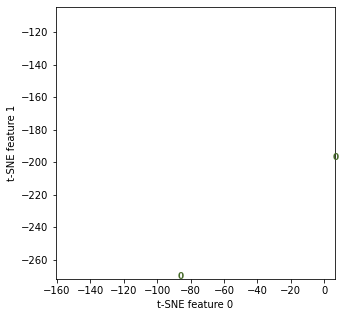

In [25]:
plt.figure(figsize=(5,5))
plt.xlim(X_embedded[:, 0].min(), X_embedded[:,0].max() + 1)
plt.ylim(X_embedded[:, 1].min(), X_embedded[:,1].max() + 1)

for i in range(len(X_embedded[0])):
    plt.text(X_embedded[i, 0], X_embedded[i, 1], str(label[i]),
             color = colors[label[i]],
             fontdict={'weight':'bold', 'size':9})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.savefig('./t_SNE_simple.png', dpi=300)
